# 10. Barrier Option Pricing using Neural Path Integral

This notebook demonstrates the **Variance Reduction** capability of the Neural Path Integral method for **Down-and-Out Put Options**.

## Theory
We use **Neural Importance Sampling** to guide option paths away from the barrier (or towards specific regions) to minimize the variance of the estimator.

$$ \text{Loss} = \text{Var} \left[ \text{Payoff}(S^u) \cdot e^{-\text{Action}(u)} \right] $$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from src.physics_engine import MarketSimulator
from src.neural_engine import NeuralImportanceSampler
from src.quantum_solver import PathIntegralSolver

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 1. Setup Environment
We define a Heston model environment and a specific Down-and-Out Put option.

In [2]:
# Parameters
S0 = 100.0
K = 90.0      # Strike
B = 80.0      # Barrier (Down-and-Out)
T = 1.0       # Maturity
r = 0.05      # Risk-free rate
dt = 0.01

# Heston Parameters
kappa = 2.0
theta = 0.04
xi = 0.3
rho = -0.7

sim = MarketSimulator(mu=r, kappa=kappa, theta=theta, xi=xi, rho=rho, device=device)
solver = PathIntegralSolver(sim)

## 2. Standard Monte Carlo (Benchmark)
We run a large-scale simulation to get a "ground truth" benchmark.

In [3]:
print("Running Standard Monte Carlo...")
N_mc = 100000
batch_size = 10000
prices_mc = []

with torch.no_grad():
    for _ in range(N_mc // batch_size):
        S, _, _, hit = sim.simulate_controlled(S0, theta, T, dt, batch_size, 
                                               barrier_level=B, barrier_type='down-out')
        S_final = S[:, -1]
        # Put Payoff
        payoff = torch.maximum(torch.tensor(K, device=device) - S_final, torch.tensor(0.0, device=device))
        # Knock-out
        payoff = payoff * (~hit).float()
        
        discounted_payoff = torch.exp(torch.tensor(-r*T, device=device)) * payoff
        prices_mc.extend(discounted_payoff.cpu().numpy())

mean_mc = np.mean(prices_mc)
std_mc = np.std(prices_mc) / np.sqrt(len(prices_mc))
print(f"Standard MC Price: {mean_mc:.4f} +/- {1.96*std_mc:.4f} (95% CI)")

Running Standard Monte Carlo...
Standard MC Price: 0.1677 +/- 0.0057 (95% CI)


## 3. Training Neural Importance Sampler
We train the neural network to minimize the variance of the weighted payoff.
Ideally, if variance -> 0, we found the optimal control.

Training Neural Control...
Iter 0: Loss (Variance) = 0.832387, Price Est = 0.1571
Iter 20: Loss (Variance) = 0.963128, Price Est = 0.1698
Iter 40: Loss (Variance) = 1.116497, Price Est = 0.1950
Iter 60: Loss (Variance) = 1.090807, Price Est = 0.1697
Iter 80: Loss (Variance) = 1.234041, Price Est = 0.1700
Iter 100: Loss (Variance) = 1.049066, Price Est = 0.1583
Iter 120: Loss (Variance) = 1.214091, Price Est = 0.1688
Iter 140: Loss (Variance) = 1.046677, Price Est = 0.1523
Iter 160: Loss (Variance) = 1.250606, Price Est = 0.1797
Iter 180: Loss (Variance) = 1.248659, Price Est = 0.1834
Iter 200: Loss (Variance) = 1.265288, Price Est = 0.1834


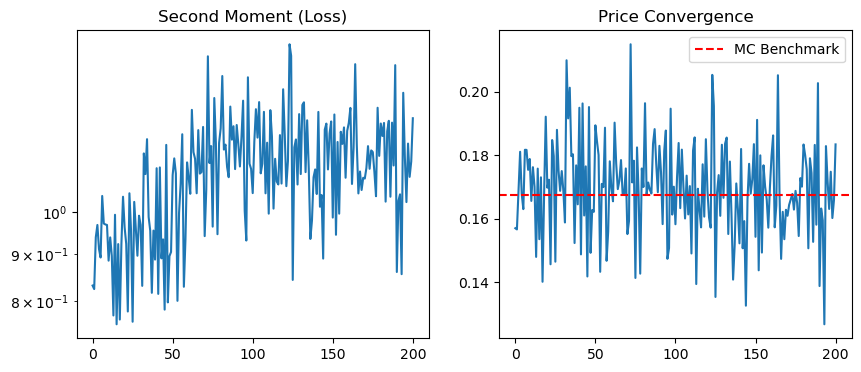

In [4]:
sampler = NeuralImportanceSampler(sim, hidden_dim=64)
# LR reduced to 0.0005 for stability with Bound=0.2
optimizer = torch.optim.Adam(sampler.control_net.parameters(), lr=0.0005)

losses = []
prices_history = []

print("Training Neural Control...")
for i in range(201):
    # Manual unroll of train_step to add gradient clipping
    sampler.control_net.train()
    optimizer.zero_grad()
    
    dt_train = min(0.01, T / 100.0)
    control_fn = sampler.get_control_fn()
    
    S_paths, _, log_weights, barrier_hit = sampler.sim.simulate_controlled(
        S0=S0, v0=sim.theta, T=T, dt=dt_train, num_paths=5000,  # Increased batch size for smoother gradients
        control_fn=control_fn, barrier_level=B, barrier_type='down-out'
    )
    
    S_final = S_paths[:, -1]
    payoffs = torch.maximum(torch.tensor(K, device=device) - S_final, 
                            torch.tensor(0.0, device=device))
    if barrier_hit is not None:
         payoffs = payoffs * (~barrier_hit).float()
    
    weighted_payoffs = payoffs * torch.exp(log_weights)
    loss = torch.mean(weighted_payoffs ** 2)
    
    loss.backward()
    
    # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(sampler.control_net.parameters(), max_norm=1.0)
    
    optimizer.step()
    
    price_est = torch.mean(weighted_payoffs).item()
    
    losses.append(loss.item())
    prices_history.append(price_est)
    
    if i % 20 == 0:
        print(f"Iter {i}: Loss (Variance) = {loss.item():.6f}, Price Est = {price_est:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Second Moment (Loss)')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(prices_history)
plt.axhline(mean_mc, color='r', linestyle='--', label='MC Benchmark')
plt.title('Price Convergence')
plt.legend()
plt.show()

## 4. Final Evaluation
We compare the variance of Standard MC vs Neural MC using the same number of paths.

In [5]:
N_eval = 5000

# 1. Neural IS
with torch.no_grad():
    sampler.control_net.eval()
    control_fn = sampler.get_control_fn()
    S, _, log_w, hit = sim.simulate_controlled(S0, theta, T, dt, N_eval, 
                                               control_fn=control_fn, barrier_level=B, barrier_type='down-out')
    S_final = S[:, -1]
    payoff = torch.maximum(torch.tensor(K, device=device) - S_final, torch.tensor(0.0, device=device))
    payoff = payoff * (~hit).float()
    weighted_payoff = payoff * torch.exp(log_w) * torch.exp(torch.tensor(-r*T, device=device))
    
    neural_mean = torch.mean(weighted_payoff).item()
    neural_std = torch.std(weighted_payoff).item()

# Standard MC (re-run with small N)
with torch.no_grad():
    S, _, _, hit = sim.simulate_controlled(S0, theta, T, dt, N_eval, 
                                               barrier_level=B, barrier_type='down-out')
    S_final = S[:, -1]
    payoff = torch.maximum(torch.tensor(K, device=device) - S_final, torch.tensor(0.0, device=device))
    payoff = payoff * (~hit).float()
    val = payoff * torch.exp(torch.tensor(-r*T, device=device))
    mc_mean = torch.mean(val).item()
    mc_std = torch.std(val).item()

print(f"Results (N={N_eval}):")
print(f"Standard MC: {mc_mean:.4f} +/- {1.96 * mc_std / np.sqrt(N_eval):.4f} (StdDev: {mc_std:.4f})")
print(f"Neural IS  : {neural_mean:.4f} +/- {1.96 * neural_std / np.sqrt(N_eval):.4f} (StdDev: {neural_std:.4f})")

if neural_std > 1e-9:
    print(f"\nVariance Reduction Ratio: {mc_std**2 / neural_std**2:.2f}x")
else:
    print(f"\nVariance Reduction Ratio: Undefined (Neural StdDev ~= 0). Suggests bias/collapse if Neural Mean != MC Mean.")

Results (N=5000):
Standard MC: 0.1718 +/- 0.0248 (StdDev: 0.8935)
Neural IS  : 0.1781 +/- 0.0304 (StdDev: 1.0958)

Variance Reduction Ratio: 0.66x
